In [1]:
# %pip install opencv-python
from utilities import ShowImage
from imgAlignment import align_board
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def filter_hough_lines(lines, min_length=300, angle_threshold=10):
    verticals = []
    horizontals = []
    for x1, y1, x2, y2 in lines[:, 0]:
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length < min_length:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle) < angle_threshold or abs(angle - 180) < angle_threshold:
            horizontals.append((x1, y1, x2, y2))
        elif abs(angle - 90) < angle_threshold or abs(angle + 90) < angle_threshold:
            verticals.append((x1, y1, x2, y2))
    return verticals, horizontals


In [52]:
def autocorp_nonblack(img, threshold=1, shrink=0.1):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to get a mask
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    coords = cv2.findNonZero(mask)
    
    if coords is None:
        return img
    
    x, y, w, h = cv2.boundingRect(coords)
    
    # shrinkg image
    shrink_w = int(w * shrink)
    shrink_h = int(h * shrink)
    
    x_new = x + shrink_w
    y_new = y + shrink_h
    w_new = w - 2 * shrink_w
    h_new = h - 2 * shrink_h

    return img[y_new:y_new+h_new, x_new:x_new+w_new]

In [3]:
def detect_board_and_warp(image, output_size=(800, 800)):
    # Load and resize image (optional)
    img = (image)
    # img = cv2.resize(img, (1000, 1000))  # scale for consistency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plot grayscaled image
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3) # the parameters are: 
                                                     # Lowthreshold(which is the lower bound for the hysteresis thresholding), 
                                                     # Highthreshold(which is the upper bound for the hysteresis thresholding), 
                                                     # and apertureSize(which is the size of the Sobel kernel used to compute the gradient).
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=100, minLineLength=70, maxLineGap=15)
    
    debug_lines = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_lines, (x1, y1), (x2, y2), (255, 0, 0), 5)
            
    # Approximate outer rectangle from Hough lines (very naive)
    # We assume that the outermost lines (bounding the board) are the longest horizontal/vertical
    verticals = []
    horizontals = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < 20:  # vertical line
            verticals.append(line[0])
        elif abs(y1 - y2) < 20:  # horizontal line
            horizontals.append(line[0])
            
    top = min(horizontals, key=lambda l: l[1])
    bottom = max(horizontals, key=lambda l: l[1])
    left = min(verticals, key=lambda l: l[0])
    right = max(verticals, key=lambda l: l[0])
    
    src_pts = np.array([
        [left[0], top[1]],
        [right[2], top[1]],
        [right[2], bottom[3]],
        [left[0], bottom[3]]
    ], dtype='float32')

    dst_pts = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype='float32')

    # Perspective warp
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, matrix, output_size)

    return img, debug_lines, warped

In [ ]:
def split_board_into_cells(warped_img, grid_X_size=16, padding=0):
    cell_height = warped_img.shape[0] // grid_X_size
    cell_width = warped_img.shape[1] // grid_X_size
    
    cells = {}
    for i in range(grid_X_size):
        for j in range(grid_X_size):
            x1 = j * cell_width
            y1 = i * cell_height
            x2 = (j + 1) * cell_width
            y2 = (i + 1) * cell_height
            
            pad_x = int(padding * cell_width)
            pad_y = int(padding * cell_height)
            
            x1 = max(0, x1 - pad_x)
            y1 = max(0, y1 - pad_y)
            x2 = min(warped_img.shape[1], x2 + pad_x)
            y2 = min(warped_img.shape[0], y2 + pad_y)
            
            # TODO: Assign the cells to the defined class inside board.py
            cell_img = warped_img[y1:y2, x1:x2]
            label = f"{chr(65 + i)}{j + 1}"  # e.g., A1, B1, ..., P16
            cells[label] = cell_img
            
    return cells

In [62]:
input_img = 'train/2_08.jpg'
template_img = "train/2_00.jpg"  # your perfect board image
query_img = input_img              # skewed image

[INFO] Good matches before filtering: 307


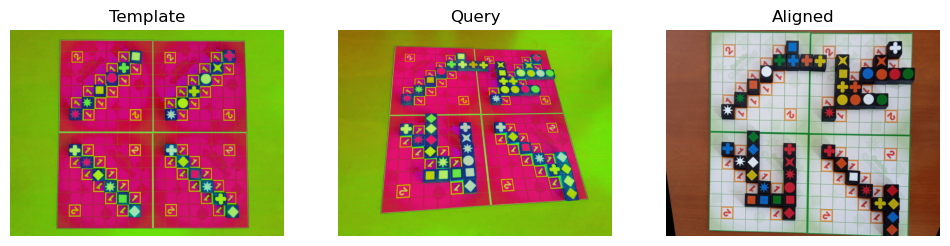

In [63]:
tpl, qry, aligned_img = align_board(template_img, query_img, output_size=(800,800), show_details=False , use_sift=True)

aligned_img = autocorp_nonblack(aligned_img, threshold=0.5, shrink=0.03)

plt.figure(figsize=(12,4))
for i, img in enumerate([tpl, qry, aligned_img], 1):
    plt.subplot(1,3,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(["Template","Query","Aligned"][i-1])
plt.show()

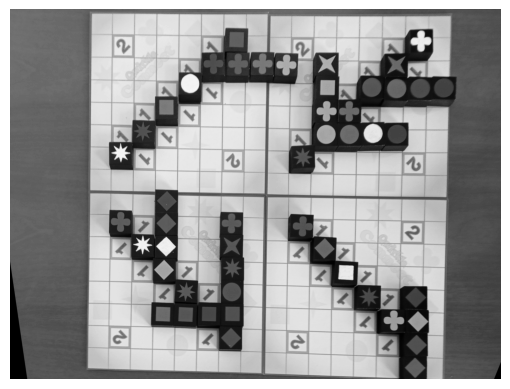

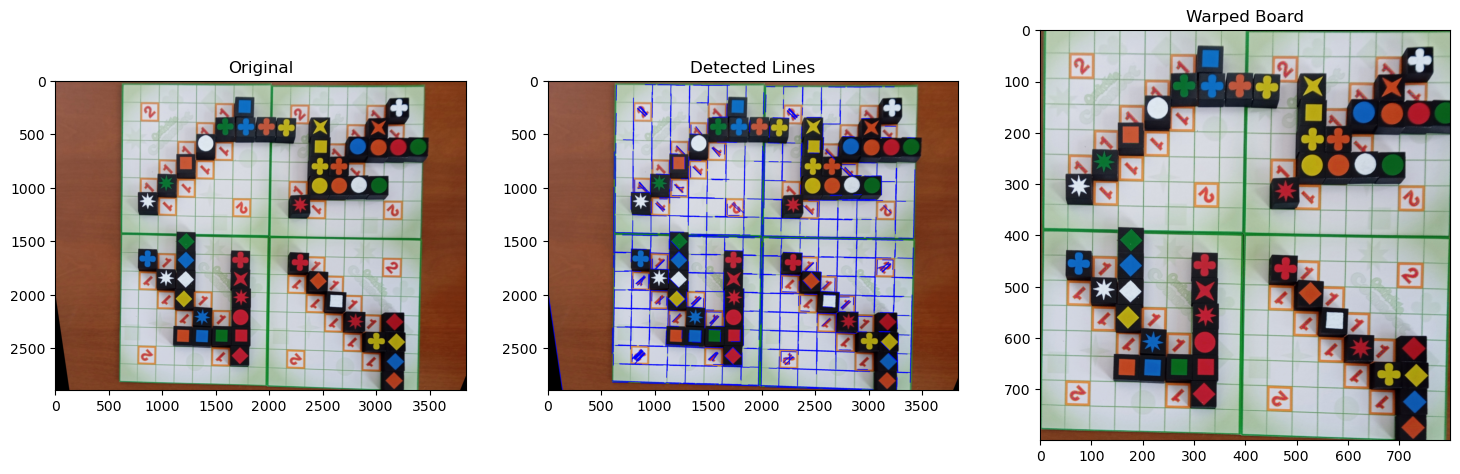

In [64]:
original, lines, warped = detect_board_and_warp(aligned_img)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(lines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

A1
A2
A3
A4
A5
A6
A7
A8
A9
A10
A11
A12
A13
A14
A15
A16
B1
B2
B3
B4
B5
B6
B7
B8
B9
B10
B11
B12
B13
B14
B15
B16
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
C15
C16
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
E1
E2
E3
E4
E5
E6
E7
E8
E9
E10
E11
E12
E13
E14
E15
E16
F1
F2
F3
F4
F5
F6
F7
F8
F9
F10
F11
F12
F13
F14
F15
F16
G1
G2
G3
G4
G5
G6
G7
G8
G9
G10
G11
G12
G13
G14
G15
G16
H1
H2
H3
H4
H5
H6
H7
H8
H9
H10
H11
H12
H13
H14
H15
H16
I1
I2
I3
I4
I5
I6
I7
I8
I9
I10
I11
I12
I13
I14
I15
I16
J1
J2
J3
J4
J5
J6
J7
J8
J9
J10
J11
J12
J13
J14
J15
J16
K1
K2
K3
K4
K5
K6
K7
K8
K9
K10
K11
K12
K13
K14
K15
K16
L1
L2
L3
L4
L5
L6
L7
L8
L9
L10
L11
L12
L13
L14
L15
L16
M1
M2
M3
M4
M5
M6
M7
M8
M9
M10
M11
M12
M13
M14
M15
M16
N1
N2
N3
N4
N5
N6
N7
N8
N9
N10
N11
N12
N13
N14
N15
N16
O1
O2
O3
O4
O5
O6
O7
O8
O9
O10
O11
O12
O13
O14
O15
O16
P1
P2
P3
P4
P5
P6
P7
P8
P9
P10
P11
P12
P13
P14
P15
P16


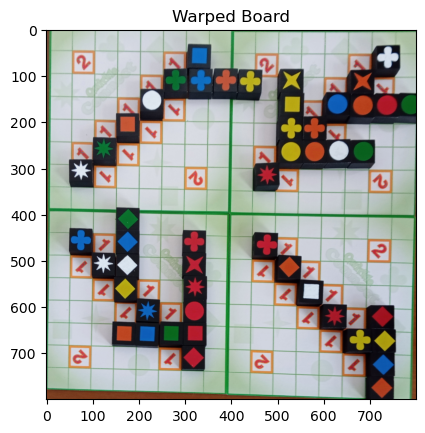

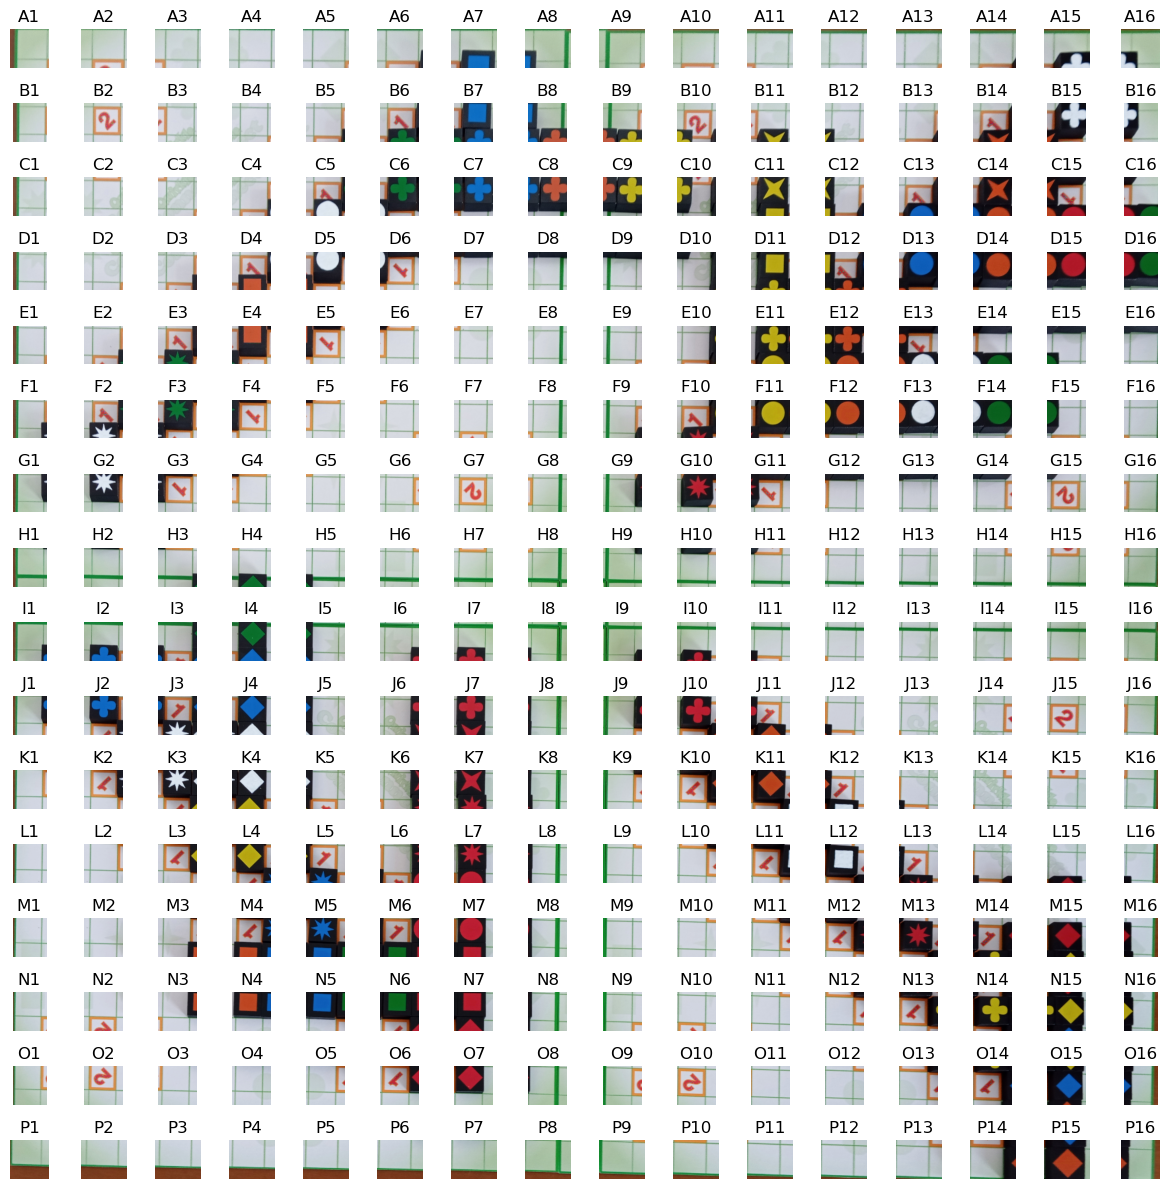

In [ ]:
from board import Board

cells_grid = split_board_into_cells(warped, 16, padding=0.2)

board = Board()
# for label in cells_grid.keys():
    # board.add_cell(label, cells_grid[label])

plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(12, 12))
for i, (label, cell_img) in enumerate(list(cells_grid.items()), 1):
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

